In [ ]:
# Original code was taken from 
# https://github.com/ievron/RegularizationAnimation/blob/main/regularization.py
!pip install --quiet celluloid cvxpy

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_36030/2031448945.py:233: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Rotating...
Moving left...
Rotating...
Moving down...
Moving right...
Moving up...
Creating animation...


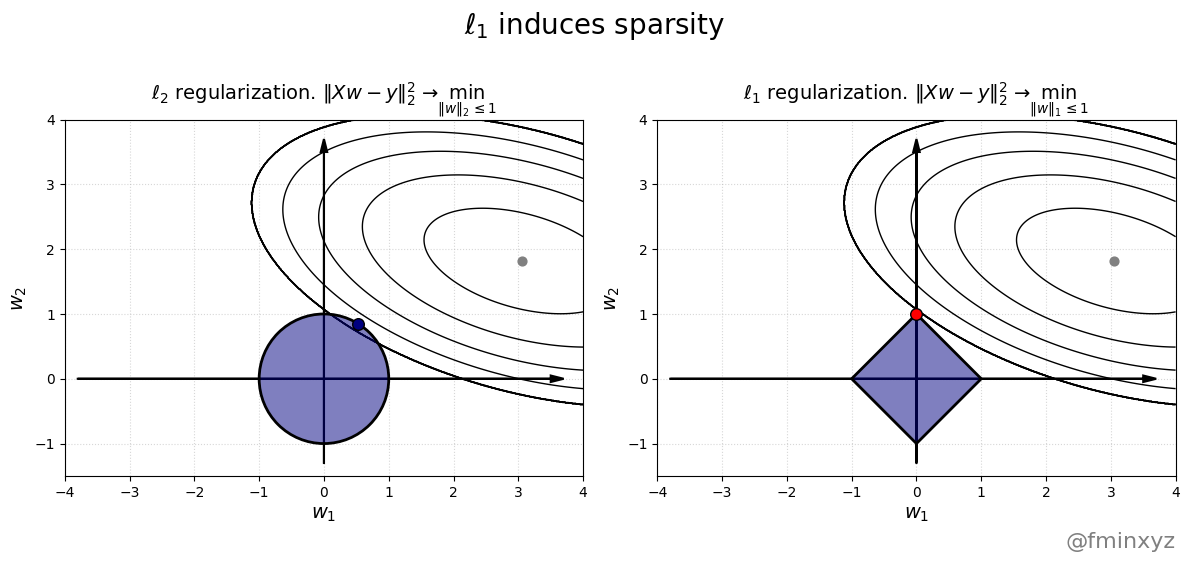

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import cvxpy as cp

# Consts
STD_NOISE = 5*10**-1
DIM = 2
NUM_SAMPLES = 15
evals = [1, 2.14] # underlying singular values
SEED = 1984

ylim = [-1.5, 4]
xlim = [-4, 4]
CONTOUR_LINES = 5
LABELS_FONTSIZE = 14
TITLE_FONTSIZE = 14
SUPTITLE_FONTSIZE = 20
FIGSIZE = (12, 6)
CONTOUR_LOSS_THRESHOLD = 20

STEPS = 100
ROTATION_STEPS = 100
w_1_range = [-2.5, 3]
w_t = [max(w_1_range), 1.8]
w_2_range = [-1.3, 1.8]

FPS = 40
SHOULD_ANIMATE = True
BALLS_COLOR = "navy"

def solve_l1_minimization(X, y):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.norm2(X @ w - y)**2)
    constraints = [cp.norm1(w) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

def solve_l2_minimization(X, y):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.norm2(X @ w - y)**2)
    constraints = [cp.norm2(w) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

def SVD(M):
    U, D, V = np.linalg.svd(M)  # V ROWS are the eigenvectors
    V = V.T
    S = np.zeros(M.shape, dtype=V.dtype)
    S[:D.shape[0], :D.shape[0]] += np.diag(D)

    return U, S, V

def generateData(NUM_SAMPLES, DIM, STD_NOISE, singularValues):
    # Not really random
    X = np.random.randn(NUM_SAMPLES, DIM)
    U, _, V = SVD(X)

    S = np.zeros(X.shape, dtype=V.dtype)
    S[:len(singularValues), :len(singularValues)] += np.diag(singularValues)
    X = U.dot(S.dot(V.T))

    noise = np.random.randn(NUM_SAMPLES).astype(np.float64) * STD_NOISE

    return X, noise

def plotUnitCircle(alpha, fc, lw):
    # Plot unit circle
    unitCircle = plt.Circle((0, 0), 1,
                            alpha=alpha, fc=fc, lw=lw, zorder=10)
    # Draw a non-transparent white edge to wipe the facecolor where they overlap
    # c_wipe = plt.Circle((0, 0), 1,
    #                     alpha=1.0, ec='white', fc='none', lw=lw, zorder=10)
    # Now draw only the edge
    c_edge = plt.Circle((0, 0), 1,
                        fc='none', ec='k', lw=lw)
    unitCircle_patch = PatchCollection([unitCircle, c_edge], match_original=True, zorder=10)
    axes[0].add_artist(unitCircle_patch)

def plotUnitDiamond(alpha, fc, lw):
    # Plot unit diamond
    diagonal = np.sqrt(2)

    rect = patches.Rectangle((-1/np.sqrt(2), -1/np.sqrt(2)), diagonal, diagonal,
                             alpha=alpha, fc=fc, zorder=10)
    # Draw a non-transparent white edge to wipe the facecolor where they overlap
    # r_wipe = patches.Rectangle((-1/np.sqrt(2), -1/np.sqrt(2)), diagonal, diagonal,
    #                            alpha=1.0, ec='white', fc='none', lw=lw, zorder=10)
    # Now draw only the edge
    r_edge =patches.Rectangle((-1/np.sqrt(2), -1/np.sqrt(2)), diagonal, diagonal,
                              fc='none', ec='k', lw=lw)
    t2 = mpl.transforms.Affine2D().rotate_deg(-45) + axes[1].transData
    rect_patch = PatchCollection([rect, r_edge], match_original=True, zorder=10)
    rect_patch.set_transform(t2)

    axes[1].add_artist(rect_patch)

def errorForSolution(X, y, sol):
    return np.linalg.norm(X.dot(sol) - y) ** 2

# Draw the axes + copyrights + norm circles
def drawStaticShapes(axes):
    for ax in axes:
        # Draw axes
        ax.arrow(xlim[0] + 0.2, 0, xlim[1] - xlim[0] - 0.5, 0., fc='k', ec='k',
                 lw=1.5, head_width=.1, head_length=.2,
                 length_includes_head= True, clip_on = False, zorder=2)

        ax.arrow(0, ylim[0] + 0.2, 0., ylim[1] - ylim[0] - 0.5, fc='k', ec='k',
                 lw=1.5, head_width=.1, head_length=.2,
                 length_includes_head= True, clip_on = False, zorder=2)


    # Plot copyrights
    axes[-1].annotate('@fminxyz',
                fontsize=16, c='grey', zorder=20,
                xy=(1, 0), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                ha='right', va='bottom')

    fc = BALLS_COLOR
    alpha = 0.5
    lw = 2
    plotUnitCircle(alpha, fc, lw)
    plotUnitDiamond(alpha, fc, lw)


def plotSolution(ax, pnt,):
    if abs(pnt[0]) <= 1e-6 or abs(pnt[1]) <= 1e-6:
        return ax.scatter(pnt[0], pnt[1], c='red', s=70, edgecolors='k', zorder=11)
    else: 
        return ax.scatter(pnt[0], pnt[1], c=BALLS_COLOR, s=70, edgecolors='k', zorder=11)

def plotContours(X, y):
    # Gather all discrete points
    delta = np.sqrt(((xlim[1] - xlim[0]) * (ylim[1] - ylim[0])) / 10 ** 6)  # Have one million grids
    Xs = np.arange(xlim[0], xlim[1], delta)
    Ys = np.arange(ylim[0], ylim[1], delta)
    Xpt, Ypt = np.meshgrid(Xs, Ys)
    Xpt2 = np.ravel(Xpt)
    Ypt2 = np.ravel(Ypt)

    # Compute all weight combinations
    Weights = np.array([Xpt2, Ypt2])
    residuals = X.dot(Weights).T - y.T
    losses = np.linalg.norm(residuals, axis=1) ** 2
    Z = losses.reshape(Xpt.shape)

    # Nullify outside a threshold value to create an ellipsis (cleaner view)
    Z[Z > CONTOUR_LOSS_THRESHOLD] = 0

    contours = []
    for ax in axes:
        contours.append(ax.contour(Xpt, Ypt, Z, CONTOUR_LINES, linewidths=1, colors='k'))

    return contours

# Plot one "frame"/setting of the system
def plot(X, U, S, V, y):
    plottedPoints = []

    # Find unconstrained (=unregularized solution)
    unregSol = V.dot(np.linalg.pinv(S).dot(U.T.dot(y)))

    # Plot contours
    contours = plotContours(X, y)

    # For l2-regularized solution
    w_opt_l2 = solve_l2_minimization(X, y)
    plottedPoints.append(plotSolution(axes[0], w_opt_l2))

    # For l1-regularized solution
    w_opt_l1 = solve_l1_minimization(X, y)
    plottedPoints.append(plotSolution(axes[1], w_opt_l1))

    # Plot unregularized solution
    for ax in axes:
        plottedPoints.append(ax.scatter(unregSol[0], unregSol[1], c='grey', s=40, zorder=11))

    if SHOULD_ANIMATE:
        # Animation handling (requires plotting *everything* again)
        drawStaticShapes(axes)
        camera.snap()
    else:
        plt.draw()
        plt.show(block=False)

        plt.pause(0.1)

        # When not animating, the fixed shapes are drawn once
        # The rest of the shapes should be cleared at each iteration
        for cntr in contours:
            for c in cntr.collections:
                c.remove()

        for pnt in plottedPoints:
            pnt.remove()


def rotateProblem(U, S, V, noise, angle):
    theta = angle * np.pi / 180

    # Create rotation matrix and rotate
    currV = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]).dot(V)
    X = U.dot(S.dot(currV.T))
    y = X.dot(w_t) + noise

    return X, y, currV

np.random.seed(SEED)

# Plotting starts
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)
plt.tight_layout(pad=1)
axes = np.ravel(axes)

# Initialize plots and axes
for ax in axes:
    ax.set_aspect('equal', adjustable='box')
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.grid(zorder=0, alpha=0.5, linestyle=":")
    ax.set_xlabel(r"$w_1$", fontsize=LABELS_FONTSIZE)
    ax.set_ylabel(r"$w_2$", fontsize=LABELS_FONTSIZE)
    plt.tight_layout()


# Set titles
plt.suptitle(r"$\ell_1$ induces sparsity", fontsize=SUPTITLE_FONTSIZE)
axes[0].set_title(r"$\ell_2$ regularization. $\|Xw - y\|_2^2 \; \to \min_{\|w\|_2 \leq 1}$", fontsize=TITLE_FONTSIZE)
axes[1].set_title(r"$\ell_1$ regularization. $\|Xw - y\|_2^2 \; \to \min_{\|w\|_1 \leq 1}$", fontsize=TITLE_FONTSIZE)


# Animation handling
if SHOULD_ANIMATE:
    from celluloid import Camera
    camera = Camera(fig)
else:
    drawStaticShapes(axes)


# Generate data
X, noise = generateData(NUM_SAMPLES, DIM, STD_NOISE, evals)
U, S, V = SVD(X)

w_t[0] = max(w_1_range)

# Rotate
print("Rotating...")
for angle in np.linspace(0, 360, ROTATION_STEPS):
    X, y, currV = rotateProblem(U, S, V, noise, angle)

    plot(X, U, S, currV, y)

# Reconstruct problem
X = U.dot(S.dot(V.T))

# Move left
print("Moving left...")
for w_1 in np.linspace(max(w_1_range), min(w_1_range), STEPS):
    w_t[0] = w_1

    X = U.dot(S.dot(V.T))
    y = X.dot(w_t) + noise

    plot(X, U, S, V, y)

# Rotate
print("Rotating...")
w_t[0] = min(w_1_range)
for angle in np.linspace(0, 360, ROTATION_STEPS):
    X, y, currV = rotateProblem(U, S, V, noise, angle)

    plot(X, U, S, currV, y)

X = U.dot(S.dot(V.T))

# Move down
print("Moving down...")
for w_2 in np.linspace(max(w_2_range), min(w_2_range), STEPS):
    w_t[1] = w_2

    X = U.dot(S.dot(V.T))
    y = X.dot(w_t) + noise

    plot(X, U, S, V, y)

# Move back right
print("Moving right...")
for w_1 in np.linspace(min(w_1_range), max(w_1_range), STEPS):
    w_t[0] = w_1

    X = U.dot(S.dot(V.T))
    y = X.dot(w_t) + noise

    plot(X, U, S, V, y)

# Move up
print("Moving up...")
for w_2 in np.linspace(min(w_2_range), max(w_2_range), STEPS):
    w_t[1] = w_2

    X = U.dot(S.dot(V.T))
    y = X.dot(w_t) + noise

    plot(X, U, S, V, y)

# Animation handling
if SHOULD_ANIMATE:
    print("Creating animation...")
    animation = camera.animate(interval=1000 // FPS, repeat=True, blit=True)
    # animation.save('Regularization.gif')
    animation.save('Regularization_horizontal.mp4', dpi=200)
else:
    plt.show()